# Hidro Sampa



## Lendo os dados do MDT por Entwine

Vamos obter os dados do MDT de uma determinada região a partir do serviço EntWine disponibilizado pelo GeoSampa

In [3]:
poligono = "Polygon ((321938.99294264818308875 7359797.26288697309792042, 321938.99294264818308875 7370960.27322614192962646, 332798.75414453825214878 7370960.27322614192962646, 332798.75414453825214878 7359797.26288697309792042, 321938.99294264818308875 7359797.26288697309792042))"

In [50]:
import pdal
import json

cropper = [
    {
      "type": "readers.ept",
      "filename": "https://ept-m3dc-pmsp.s3-sa-east-1.amazonaws.com/ept.json",
      "bounds": "([321938, 332798],[7359797, 7370960])",
      "resolution": 100,
      "threads":6
    },
#     {
#       "type":"filters.assign",
#       "assignment":"Classification[:]=0"
#     },
#     {
#       "type":"filters.elm"
#     },
#     {
#       "type":"filters.outlier"
#     },
#     {
#         "type": "filters.ferry",
#         "dimensions": "=>ReturnNumber, =>NumberOfReturns" 
#     },
#     {
#         "type": "filters.assign",
#         "assignment": "NumberOfReturns[:]=1"
#     },
#     {
#         "type": "filters.assign",
#         "assignment": "ReturnNumber[:]=1"
#     },
#     {
#       "type":"filters.smrf",
#       "cell": 10,
# #       "last":'true',
#       "ignore":"Classification[7:7]",
#       "slope":0.2,
#       "window":16,
#       "threshold":0.45,
#       "scalar":1.2
#     },
    {
      "type":"filters.range",
      "limits":"Classification[2:2]"
    },
    {
      "filename":"./resultados/dtm_mdt.tif",
      "gdaldriver":"GTiff",
      "output_type":"all",
      "resolution":"10.0",
      "type": "writers.gdal"
    }
]

pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print(f'Pipeline selected {n_points} points')



CPU times: user 1min 17s, sys: 1.96 s, total: 1min 19s
Wall time: 48.7 s
Pipeline selected 3879702 points


In [51]:
import pandas as pd

arr = pipeline.arrays[0]
df = pd.DataFrame(arr)
df

X           Y       Z  Intensity  ReturnNumber  \
0        326720.09  7367896.65  731.46         10             1   
1        326736.65  7368033.50  737.24         23             1   
2        326853.20  7367937.04  730.17         35             1   
3        326882.02  7368119.28  729.81          5             1   
4        323903.06  7368649.10  740.33         11             2   
...            ...         ...     ...        ...           ...   
3879697  332752.29  7368572.54  762.18          7             2   
3879698  332782.63  7368563.32  767.19          5             4   
3879699  332759.67  7368567.82  763.06          5             2   
3879700  332791.34  7368558.38  769.72          8             2   
3879701  332755.36  7368558.87  762.58         11             2   

         NumberOfReturns  ScanDirectionFlag  EdgeOfFlightLine  Classification  \
0                      1                  0                 0               2   
1                      1                  0                 0               2   
2                      1                  1                 0               2   
3                      1                  1                 0               2   
4                      2                  0                 0               2   
...                  ...                ...               ...             ...   
3879697                2                  1                 0               2   
3879698                4                  0                 0               2   
3879699                2                  0                 0               2   
3879700                2                  0                 0               2   
3879701                2                  1                 0               2   

         ScanAngleRank  UserData  PointSourceId        GpsTime    Red  Green  \
0                 13.0         0             13  391065.451249  46848  45824   
1                -11.0         0             13  391234.953428  19968  22528   
2                -13.0         0             13  391817.065785  30720  30208   
3                 13.0         0             13  391970.987055  41728  40192   
4                 -3.0         0             13  392753.271702  19712  23808   
...                ...       ...            ...            ...    ...    ...   
3879697          -10.0         0             20  389385.795755  20224  25344   
3879698           -8.0         0             20  389385.848936  25344  27904   
3879699           -9.0         0             20  389385.849526  17408  23296   
3879700           -8.0         0             20  389385.903268  19712  24064   
3879701          -10.0         0             20  389386.014081  15872  22272   

          Blue  OriginId  
0        43776      1104  
1        22272      1104  
2        27392      1104  
3        36864      1104  
4        17408      1081  
...        ...       ...  
3879697  21504      1189  
3879698  23040      1189  
3879699  17920      1189  
3879700  20224      1189  
3879701  15104      1189  

[3879702 rows x 17 columns]

## Acessando o raster gerado

Agora que os dados de MDT foram convertidos para raster, vamos utilizar a lib `rasterio`para acessá-los

In [52]:
import rasterio

In [53]:
dataset = rasterio.open('./resultados/dtm_mdt.tif')

In [54]:
dataset.bounds

BoundingBox(left=321938.0, bottom=7359797.0, right=332808.0, top=7370967.0)

In [55]:
dataset.crs

CRS.from_epsg(31983)

In [56]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'float64',
 2: 'float64',
 3: 'float64',
 4: 'float64',
 5: 'float64',
 6: 'float64'}

In [57]:
from rasterio.plot import show

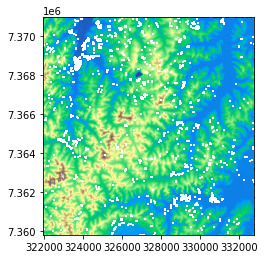

In [58]:
show(dataset, cmap='terrain')

### Preenchendo pixels vazios

In [82]:
from rasterio import fill, mask

In [60]:
dataset_filled = fill.fillnodata(dataset.read(3), mask=dataset.read_masks(3))

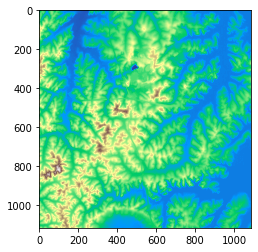

In [61]:
show(dataset_filled, cmap='terrain')

In [62]:
dataset.transform

Affine(10.0, 0.0, 321938.0,
       0.0, -10.0, 7370967.0)

In [63]:
dataset_filled.tofile('./resultados/dtm_filled.tif')

with rasterio.open(
    './resultados/dtm_filled.tif',
    'w',
    driver = 'GTiff',
    height = dataset_filled.shape[0],
    width = dataset_filled.shape[1],
    count = 1,
    dtype = dataset_filled.dtype,
    crs = 'epsg:31983',
    transform = dataset.transform
) as dst:
    dst.write(dataset_filled, 1)

## Calculando as bacias e cursos dágua

Para essa finalidade vamos utilizar a biblioteca `pysheds` de autoria de [Matt Bartos](https://github.com/mdbartos) que pode ser obtida no repositório https://github.com/mdbartos/pysheds

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
# import mplleaflet
%matplotlib inline

In [147]:
grid = Grid.from_raster('./resultados/dtm_filled.tif', data_name='dem', blockxsize=16, blockysize=16)

In [148]:
from matplotlib import pyplot as plt

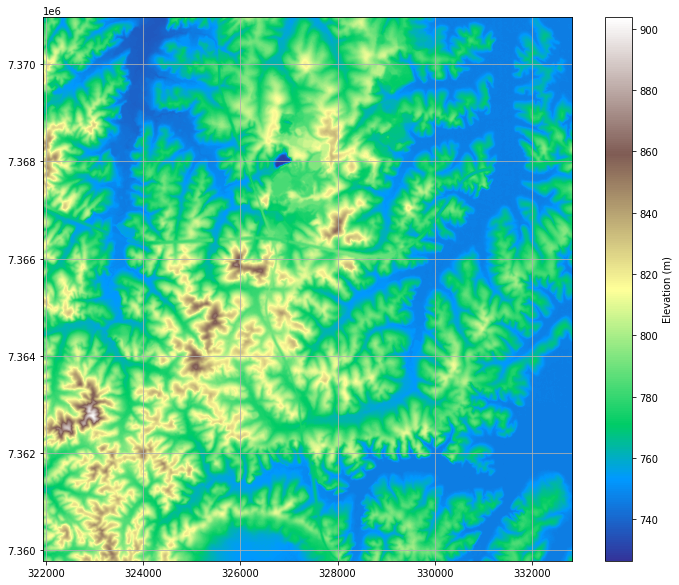

In [149]:
def plotFigure(data, label, cmap='terrain'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

plotFigure(grid.view('dem'), 'Elevation (m)')

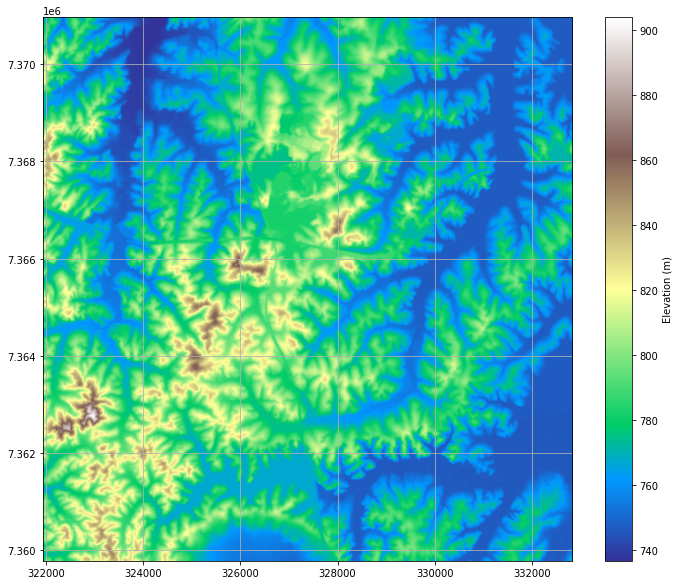

In [150]:
# Detect depressions
depressions = grid.detect_depressions('dem')
grid.fill_depressions(data='dem', out_name='flooded_dem')

# Plot depressions
plotFigure(grid.view('flooded_dem'), 'Elevation (m)')


In [151]:
depressions = grid.detect_depressions('flooded_dem')
depressions.any()

True

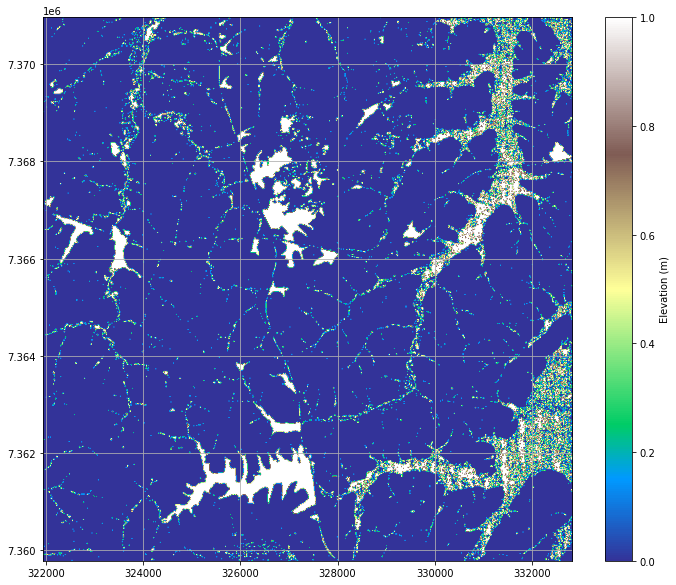

In [152]:
# Detect flats
flats = grid.detect_flats('flooded_dem')

# Plot flats
plotFigure(flats, 'Elevation (m)')
# plt.imshow(flats)


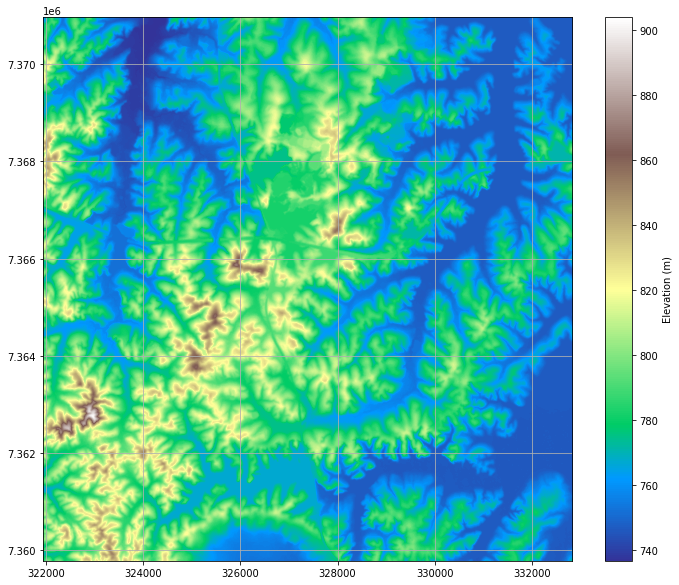

In [153]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
plotFigure(grid.view('inflated_dem'), 'Elevation (m)')

In [154]:
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow direction based on corrected DEM
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)


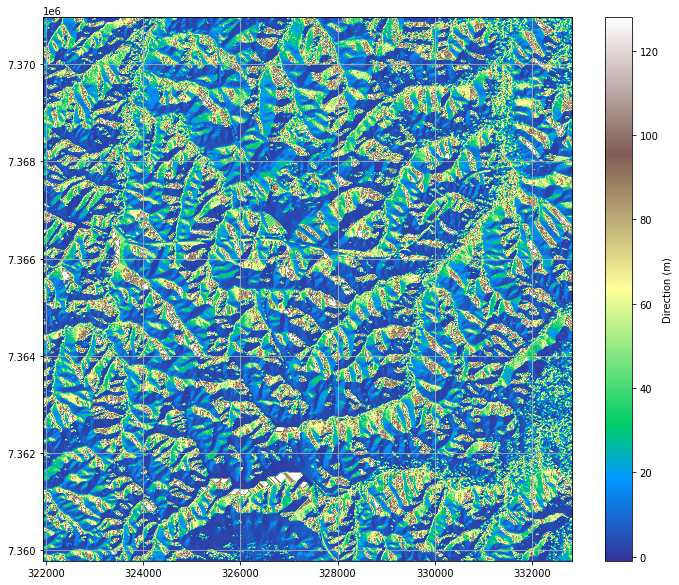

In [155]:
plotFigure(grid.view('dir'), 'Direction (m)')

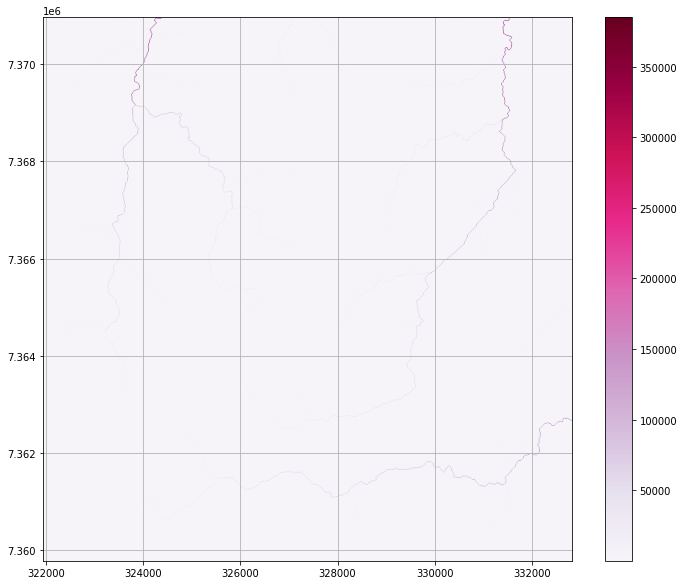

In [156]:
plotFigure(grid.view('acc'), '', cmap='PuRd')

In [157]:
# grid.to_raster('acc', './resultados/acc.tif', view=False, blockxsize=16, blockysize=16)


In [167]:
branches = grid.extract_river_network('dir', 'acc', threshold=500)

In [168]:
len(branches['features'])

1243

In [169]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

saveDict(branches, './resultados/cusros_dagua.geojson')

In [161]:
from shapely.geometry import shape
rios = shape(branches['features'][0].geometry)

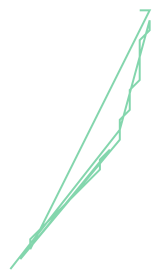

In [162]:
rios

In [163]:
import numpy as np

Text(0, 0.5, 'Latitude')

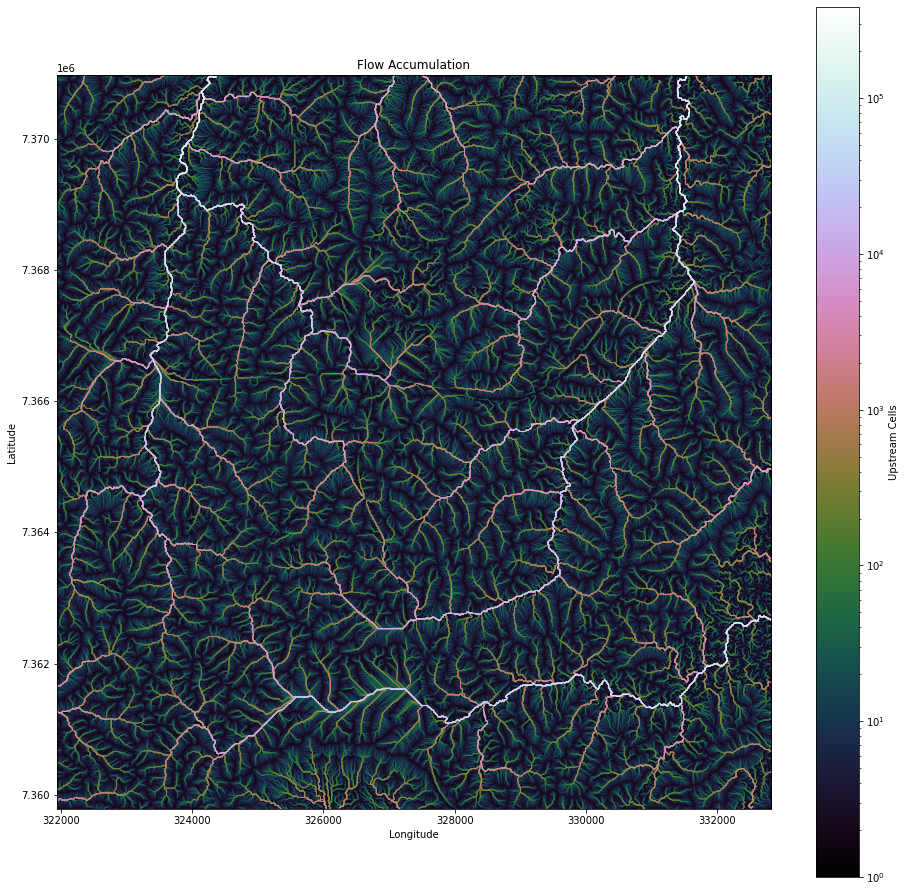

In [164]:
fig, ax = plt.subplots(figsize=(16,16))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.savefig('img/flow_accumulation.png', bbox_inches='tight')

In [165]:
grid.shape

(1117, 1087)

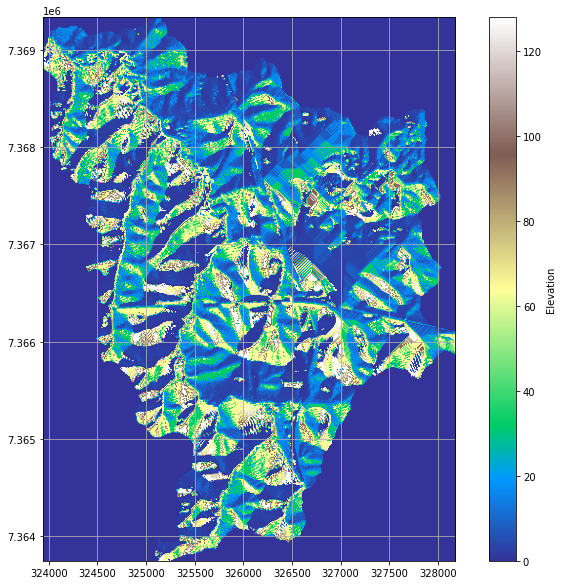

In [171]:
# Specify pour point
x, y = 323987.99954,7369127.00135

grid.snap_to_mask

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to('catch')

plotFigure(grid.view('catch'),'Elevation')


In [172]:
grid.shape

(558, 423)

In [173]:
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)



Text(0.5, 1.0, 'Flow Distance')

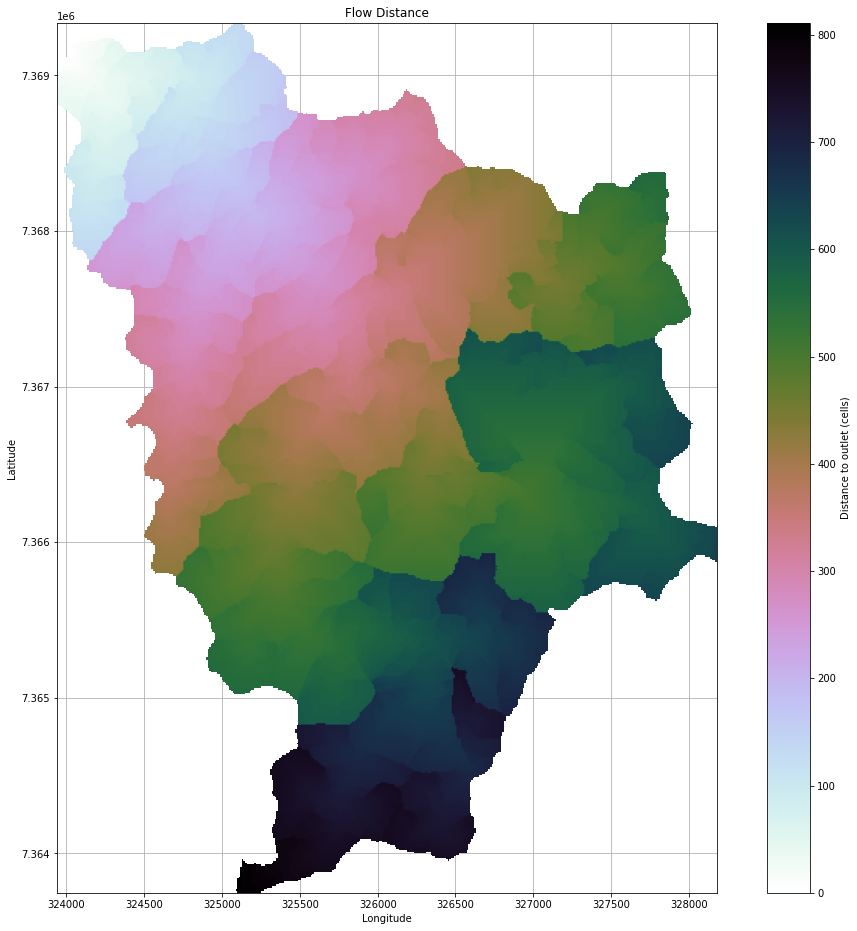

In [175]:


fig, ax = plt.subplots(figsize=(18,16))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance')

In [182]:
# Convert catchment raster to vector and combine with soils shapefile
# ---------------------
# Read soils shapefile
import geopandas as gpd
from shapely import geometry, ops
# soils = gpd.read_file('nrcs-soils-tarrant_439.shp')
# Convert catchment raster to vector geometry and find intersection
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])
# soils = soils[soils.intersects(catchment_polygon)]
# catchment_soils = soils.intersection(catchment_polygon)

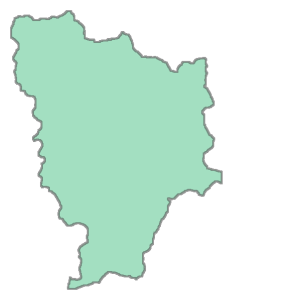

In [183]:
catchment_polygon